In [1]:
from utils import *
from pathlib import Path

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_x, path_y):
        
        self.data_x = torch.load(path_x)
        self.data_y = torch.load(path_y)
    
    def __getitem__(self, index):

        return self.data_x[index].clone(), self.data_y[index]   
    
    def __len__(self):
        return len(self.data_x)

## Define a model

In [3]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = X.reshape(*X.shape[:2],-1)
        out, _ = self.lstm(X)
        out = self.fc(out[:, -1])
        pos_out = torch.sigmoid(out)
        
        return pos_out

In [4]:
# Defining hyperparams
BATCH_SIZE = 64
NUM_SEQUENCE = 168
NUM_FEATURES = 10*129
NUM_LAYERS = 3
OUTPUT_SIZE = 1
HIDDEN_SIZE = 64
INPUT_SIZE = NUM_FEATURES

In [5]:
## get total number of chunks for training
total_train_chunks = len(list(Path("./data/saved_train_val_data/").glob("X_train_17_08_*.pt")))

In [6]:
val_dataset = CustomDataset("./data/saved_train_val_data/X_val_17_08.pt", 
                            "./data/saved_train_val_data/y_val_17_08.pt")

# Create a DataLoader to handle batching
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Creating model

In [7]:
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
model.to(DEVICE)
# Defining Loss function
criterion = nn.MSELoss()  
# Defining optimizer
lr = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

In [8]:
num_epochs = 20
history = []

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr=0.001, cycle_momentum=False)

val_min_loss = None

model_name = input("Input proper model name:\t")

Input proper model name:	model_with_chunks


## Training

In [9]:
chunk_number = 0
train_dataset = CustomDataset(f"./data/saved_train_val_data/X_train_17_08_{chunk_number}.pt", 
                        f"./data/saved_train_val_data/y_train_17_08_{chunk_number}.pt")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    model.train()
    
    for i, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):

        # Every data instance is an input + label pair
        X_train1, y_train1 = batch[0].to(torch.float32).to(DEVICE), batch[1].to(torch.float32).to(DEVICE)

        # Make predictions for this batch
        outputs = model(X_train1)

        # Compute the loss and its gradients
        loss = criterion(outputs, y_train1)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        scheduler.step()
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Gather data and report
        train_running_loss += loss.item()
    
    model.eval()
    val_running_loss = 0.
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_dataloader, position=0, leave=True)):

            # Every data instance is an input + label pair
            X_val1, y_val1 = batch[0].to(torch.float32).to(DEVICE), batch[1].to(torch.float32).to(DEVICE)

            # Make predictions for this batch
            outputs = model(X_val1)
            # Compute the loss and its gradients
            loss = criterion(outputs, y_val1)
            
            # Gather data and report
            val_running_loss += loss.item()

    mean_train_loss = train_running_loss/len(train_dataloader)
    mean_val_loss = val_running_loss/len(val_dataloader)
    
    if val_min_loss is None:
        val_min_loss = mean_val_loss
    else:
        if mean_val_loss < val_min_loss:
            val_min_loss = mean_val_loss
            torch.save(model.state_dict(), f'./models/{model_name}.pth')
    
    history.append([mean_train_loss, mean_val_loss])
    
    # change the chunk number
    
    if (epoch % (num_epochs // total_train_chunks) == 0) and (epoch != 0):
        del train_dataset
        print("Selecting next chunk for training....")
        chunk_number = (chunk_number + 1) % total_train_chunks
    !echo "ararat" | sudo -S sh -c 'echo 3 > /proc/sys/vm/drop_caches'
    print(f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}")

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [1/20]
Train Loss: 0.0458
Val Loss: 0.0361


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [2/20]
Train Loss: 0.0348
Val Loss: 0.0341


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [3/20]
Train Loss: 0.0334
Val Loss: 0.0358


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [4/20]
Train Loss: 0.0324
Val Loss: 0.0317


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [5/20]
Train Loss: 0.0313
Val Loss: 0.0315


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [6/20]
Train Loss: 0.0311
Val Loss: 0.0301


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [7/20]
Train Loss: 0.0302
Val Loss: 0.0293


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [8/20]
Train Loss: 0.0294
Val Loss: 0.0295


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [9/20]
Train Loss: 0.0285
Val Loss: 0.0289


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [10/20]
Train Loss: 0.0287
Val Loss: 0.0288


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [11/20]
Train Loss: 0.0273
Val Loss: 0.0284


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [12/20]
Train Loss: 0.0269
Val Loss: 0.0273


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [13/20]
Train Loss: 0.0259
Val Loss: 0.0265


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [14/20]
Train Loss: 0.0258
Val Loss: 0.0288


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [15/20]
Train Loss: 0.0256
Val Loss: 0.0256


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [16/20]
Train Loss: 0.0252
Val Loss: 0.0254


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [17/20]
Train Loss: 0.0251
Val Loss: 0.0251


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [18/20]
Train Loss: 0.0251
Val Loss: 0.0261


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [19/20]
Train Loss: 0.0258
Val Loss: 0.0253


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/bin/bash: /home/server3090ti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[sudo] password for server3090ti: Epoch [20/20]
Train Loss: 0.0251
Val Loss: 0.0274


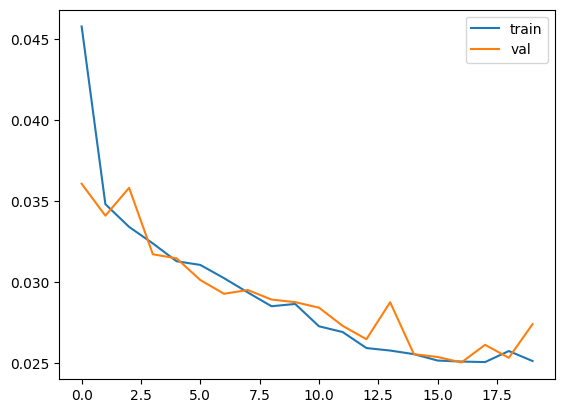

In [10]:
history = np.array(history)
plt.plot(history)
plt.legend(["train", "val"])
plt.show()

In [11]:
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
model.load_state_dict(torch.load("models/model_with_chunks.pth"))
model.to(DEVICE);

In [12]:
X_val = torch.load("data/saved_train_val_data/X_val_17_08.pt")
y_val = torch.load("data/saved_train_val_data/y_val_17_08.pt")

model.eval()
preds = model(X_val[:3000].to(torch.float32).to(DEVICE)).detach().cpu().numpy()
ground_truth = (y_val[:3000]).numpy()

# MAE

In [13]:
print(np.abs(preds - ground_truth).mean().round(4))

0.1119


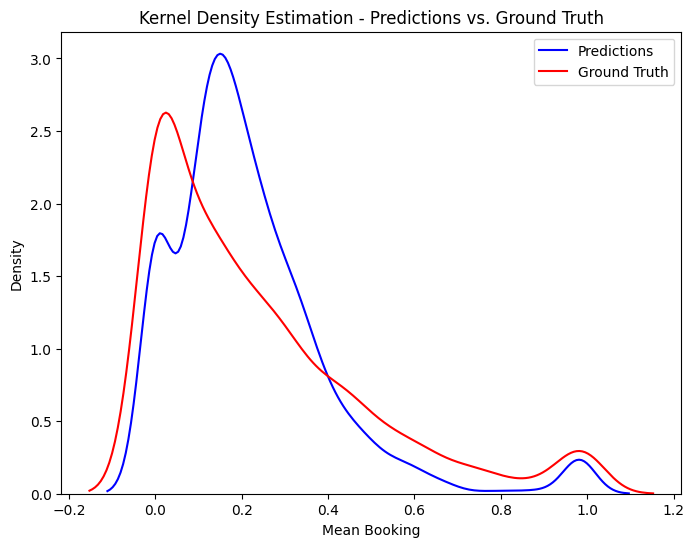

In [14]:
# Create KDE plots for predictions and ground truth
plt.figure(figsize=(8, 6))
sns.kdeplot(preds.squeeze(), label='Predictions', color='blue')
sns.kdeplot(ground_truth.squeeze(), label='Ground Truth', color='red')

# Set labels and title
plt.xlabel('Mean Booking')
plt.ylabel('Density')
plt.title('Kernel Density Estimation - Predictions vs. Ground Truth')
plt.legend()

# Show the plot
plt.show()

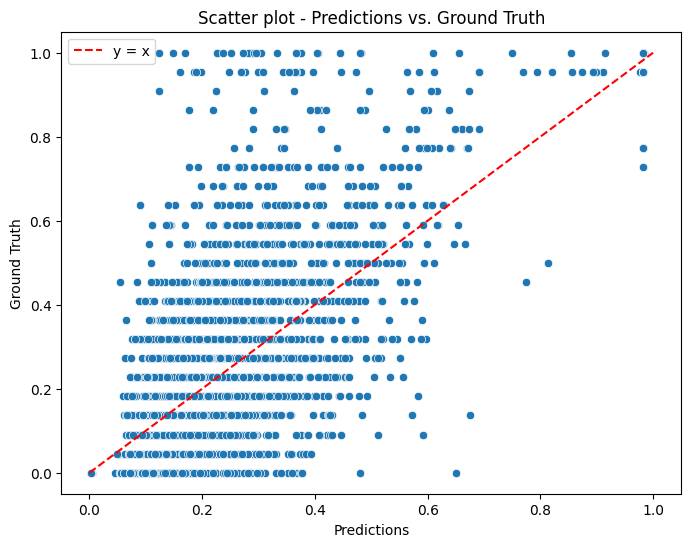

In [15]:
# Create a diagonal line for y = x
x_values = np.linspace(min(preds[..., 0].min(), ground_truth[..., 0].min()), max(preds[..., 0].max(), ground_truth[..., 0].max()), 100)
y_values = x_values

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=preds[..., 0], y=ground_truth[..., 0])

# Plot the diagonal line
plt.plot(x_values, y_values, color='red', linestyle='dashed', label='y = x')

# Set labels and title
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('Scatter plot - Predictions vs. Ground Truth')

# Show the plot
plt.legend()
plt.show()
